In [369]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/jgoppert/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [370]:
import px4tools.ulog
import pandas
import os
import pickle
import scipy.interpolate
import px4tools.version

rcParams['lines.linewidth'] = 2

In [371]:
pandas.__version__

'0.19.2'

In [372]:
px4tools.version.git_revision

'f0b3f6b5954060ca6f7c08759805468bda0fa5dd'

In [373]:
d_gyro = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/logs/01-18-17-gyro-bias.ulg',
    msg_filter='sensor_gyro',
    processing_func=lambda x: x['sensor_gyro_0'].resample('1 s').agg('mean'),
    save_path='./logs/01-18-17-gyro-bias-sensor_gyro_0.pkl',
    force_processing=False)

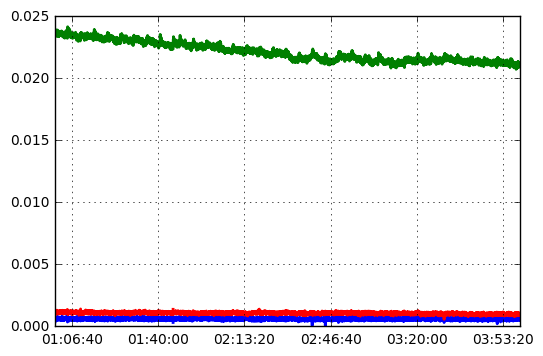

In [374]:
d_gyro['1 h': '3 h'].t_sensor_gyro_0__f_x.plot()
d_gyro['1 h': '3 h'].t_sensor_gyro_0__f_y.plot()
d_gyro['1 h': '3 h'].t_sensor_gyro_0__f_z.plot()
plt.grid()

In [377]:
d_comb = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/logs/01-18-17-gyro-bias.ulg',
    msg_filter='',
    processing_func=lambda x: x,
    save_path='/home/jgoppert/logs/01-18-17-gyro-bias-comb.pkl',
    force_processing=False)

In [378]:
d_gyro_bias = d_comb.concat(dt=1).ffill().bfill()['2 min': '60 m']

In [379]:
def plot_gyro_bias(d):
    for i, axis, color in zip([7, 8, 9], ['x', 'y', 'z'], ['r', 'g', 'b']):
        est =  getattr(d, 't_estimator_status_0__f_states_{:d}_'.format(i))
        est.plot(label=axis + ' est', style=color + '--')
        true = getattr(d, 't_sensor_gyro_0__f_{:s}'.format(axis))
        true.plot(label=axis, style=color, alpha=0.5)
    plt.gcf().autofmt_xdate()
    legend(ncol=3, loc='best')
    plt.ylabel('rad/s')
    plt.title('gyro bias')

def plot_gyro_bias_error(d):
    (d.t_estimator_status_0__f_states_7_ - d.t_sensor_gyro_0__f_x).plot(label='x', style='r')
    (d.t_estimator_status_0__f_states_8_ - d.t_sensor_gyro_0__f_y).plot(label='y', style='g')
    (d.t_estimator_status_0__f_states_9_ - d.t_sensor_gyro_0__f_z).plot(label='z', style='b')
    plt.gcf().autofmt_xdate()
    legend(ncol=3, loc='best')
    plt.title('gyro bias error')

In [380]:
def plot_accel_bias(d):
    for i, axis, color in zip([10, 11, 12], ['x', 'y', 'z'], ['r', 'g', 'b']):
        est =  getattr(d, 't_estimator_status_0__f_states_{:d}_'.format(i))
        est.plot(label=axis + ' est', style=color + '--')
        true = getattr(d, 't_sensor_accel_0__f_{:s}'.format(axis))
        if axis == 'z':
            true = pandas.Series(true + 9.8)
        true.plot(label=axis, style=color, alpha=0.5)
            
    plt.ylabel('m/s^2')
    plt.gcf().autofmt_xdate()
    legend(ncol=3, loc='best')
    plt.title('accel bias')

def plot_accel_bias_error(d):
    (d.t_estimator_status_0__f_states_10_ - d.t_sensor_accel_0__f_x).plot(label='x', style='r')
    (d.t_estimator_status_0__f_states_11_ - d.t_sensor_accel_0__f_y).plot(label='y', style='g')
    (d.t_estimator_status_0__f_states_12_ - d.t_sensor_accel_0__f_z - 9.8).plot(label='z', style='b')

(-0.02, 0.02)

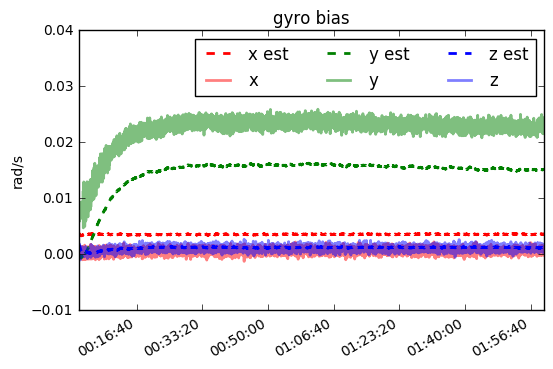

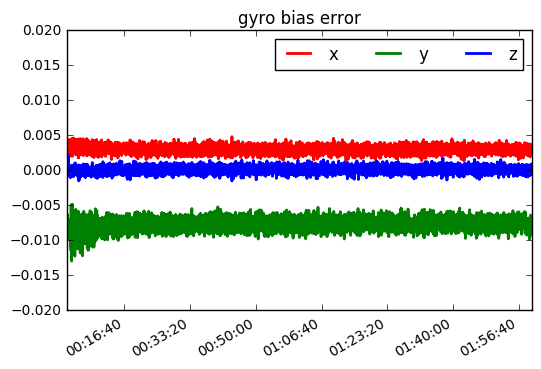

In [381]:
figure()
plot_gyro_bias(d_gyro_bias)
gca().set_ylim(-0.01, 0.04)

figure()
plot_gyro_bias_error(d_gyro_bias)
gca().set_ylim(-0.02, 0.02)

(-0.4, 0.4)

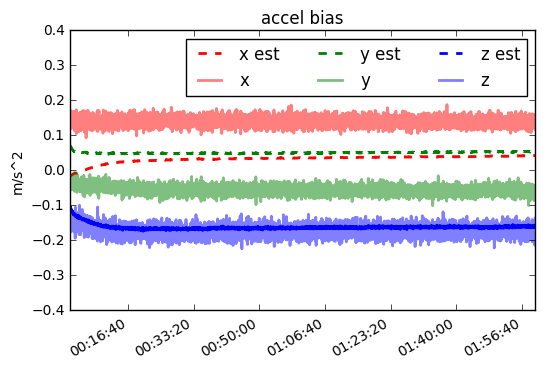

In [382]:
plot_accel_bias(d_gyro_bias)
gca().set_ylim(-0.4, 0.4)

In [385]:
est_status = d_comb['estimator_status_0']

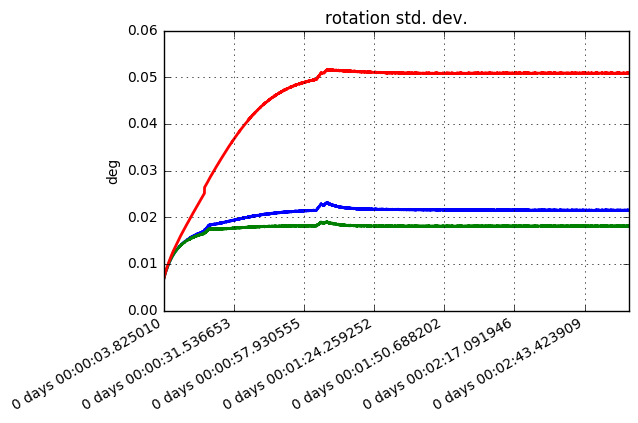

In [433]:
def plot_rotation_std_dev(d):
    for i in range(3):
        data = getattr(d, 't_estimator_status_0__f_covariances_{:d}_'.format(i))
        np.rad2deg(sqrt(data)).plot()
    plt.ylabel('deg')
    plt.title('rotation std. dev.')
    plt.grid()

plot_rotation_std_dev(est_status[:'2 m'])

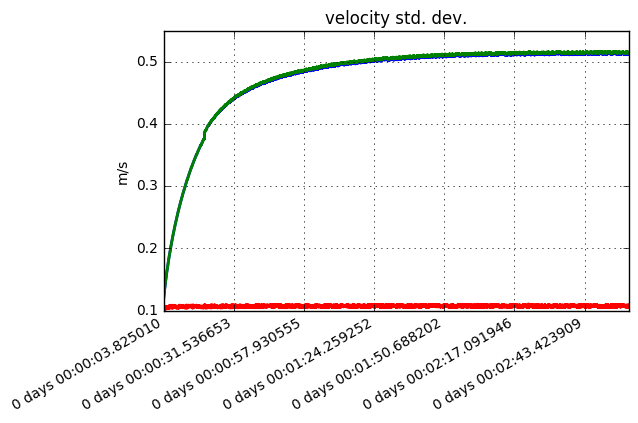

In [438]:
def plot_velocity_std_dev(d):
    for i in range(3, 6):
        data = getattr(d, 't_estimator_status_0__f_covariances_{:d}_'.format(i))
        sqrt(data).plot()
    plt.ylabel('m/s')
    plt.title('velocity std. dev.')
    plt.grid()

plot_velocity_std_dev(est_status[:'2 m'])

In [439]:
px4tools.IEKF_STATES

{0: 'q_nb_0',
 1: 'q_nb_1',
 2: 'q_nb_2',
 3: 'q_nb_3',
 4: 'vel_N',
 5: 'vel_E',
 6: 'vel_D',
 7: 'gyro_bias_bx',
 8: 'gyro_bias_by',
 9: 'gyro_bias_bz',
 10: 'accel_bias_bx',
 11: 'accel_bias_by',
 12: 'accel_bias_bz',
 13: 'pos_N',
 14: 'pos_E',
 15: 'pos_D',
 16: 'terrain_alt',
 17: 'baro_bias'}

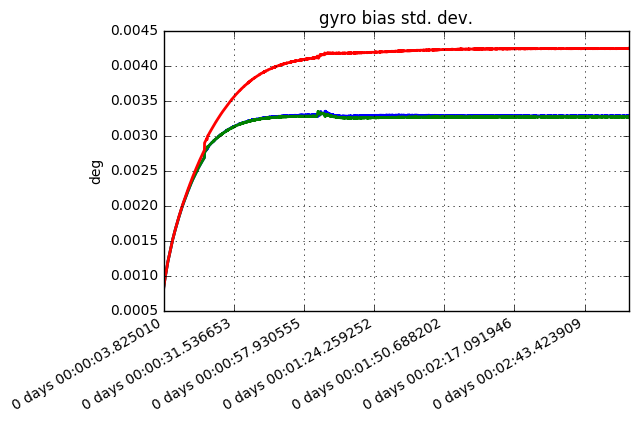

In [440]:
def plot_gyro_bias_std_dev(d):
    for i in range(6, 9):
        data = getattr(d, 't_estimator_status_0__f_covariances_{:d}_'.format(i))
        np.rad2deg(sqrt(data)).plot()
    plt.ylabel('deg')
    plt.title('gyro bias std. dev.')
    plt.grid()

plot_gyro_bias_std_dev(est_status[:'2 m'])

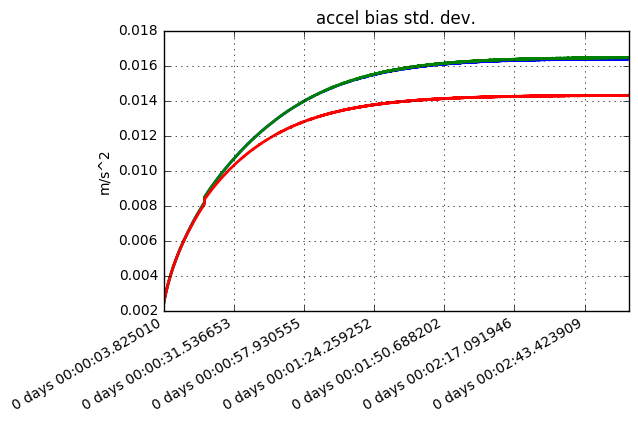

In [443]:
def plot_accel_bias_std_dev(d):
    for i in range(9, 12):
        data = getattr(d, 't_estimator_status_0__f_covariances_{:d}_'.format(i))
        sqrt(data).plot()
    plt.ylabel('m/s^2')
    plt.title('accel bias std. dev.')
    plt.grid()

plot_accel_bias_std_dev(est_status[:'2 m'])

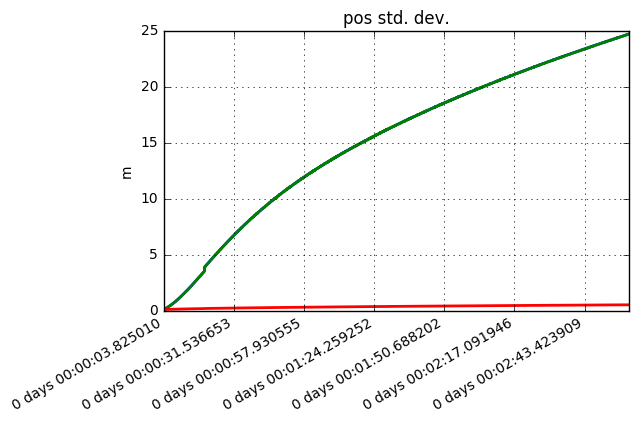

In [445]:
def plot_pos_std_dev(d):
    for i in range(12, 15):
        data = getattr(d, 't_estimator_status_0__f_covariances_{:d}_'.format(i))
        sqrt(data).plot()
    plt.ylabel('m')
    plt.title('pos std. dev.')
    plt.grid()

plot_pos_std_dev(est_status[:'2 m'])

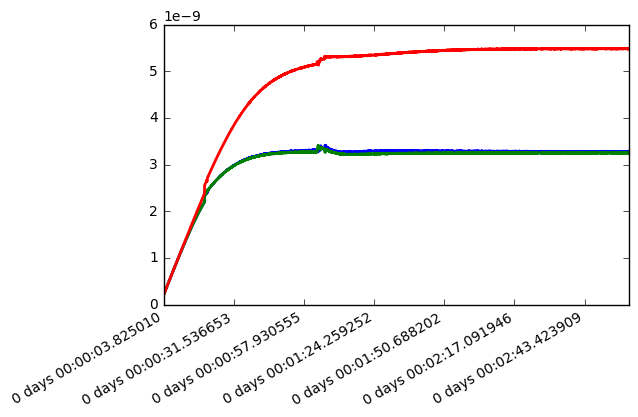

In [406]:
def plot_pos_std_dev(d):
    for i in range(12, 15):
        data = getattr(d, 't_estimator_status_0__f_covariances_{:d}_'.format(i))
        sqrt(data).plot()
    plt.ylabel('m')
    plt.title('pos std. dev.')
    plt.grid()

plot_pos_std_dev(est_status[:'2 m'])

In [407]:
px4tools.ulog.IEKF_ERROR_STATES

{0: 'rot_N',
 1: 'rot_E',
 2: 'rot_D',
 3: 'vel_N',
 4: 'vel_E',
 5: 'vel_D',
 6: 'gyro_bias_N',
 7: 'gyro_bias_E',
 8: 'gyro_bias_D',
 9: 'accel_bias_N',
 10: 'accel_bias_E',
 11: 'accel_bias_D',
 12: 'pos_N',
 13: 'pos_E',
 14: 'pos_D',
 15: 'terrain_alt',
 16: 'baro_bias'}

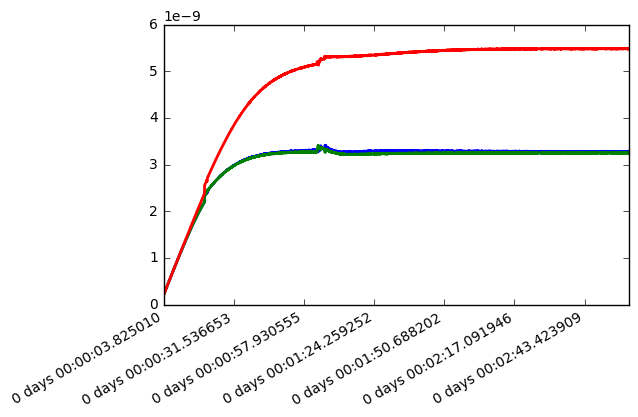

In [408]:
est_status.t_estimator_status_0__f_covariances_6_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_7_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_8_[:'2 m'].plot()

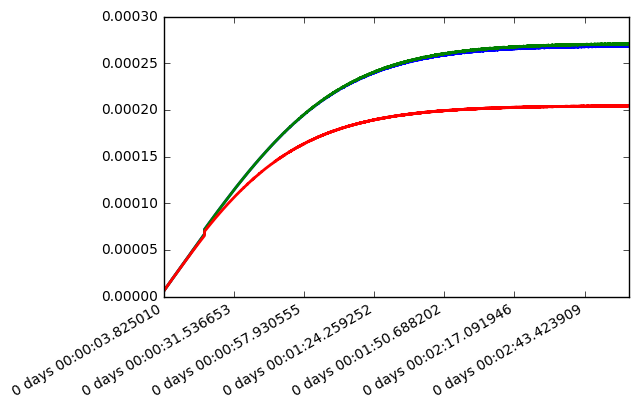

In [409]:
est_status.t_estimator_status_0__f_covariances_9_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_10_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_11_[:'2 m'].plot()

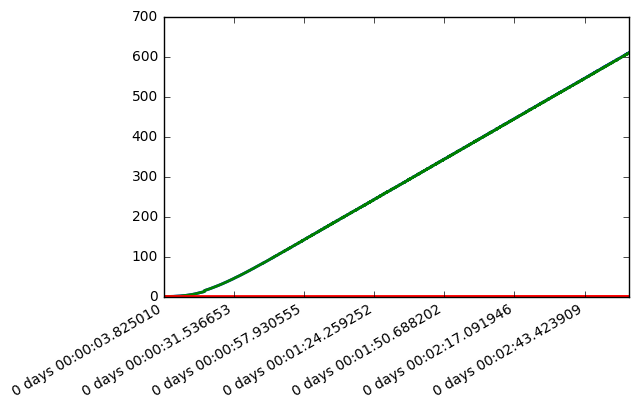

In [410]:
est_status.t_estimator_status_0__f_covariances_12_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_13_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_14_[:'2 m'].plot()

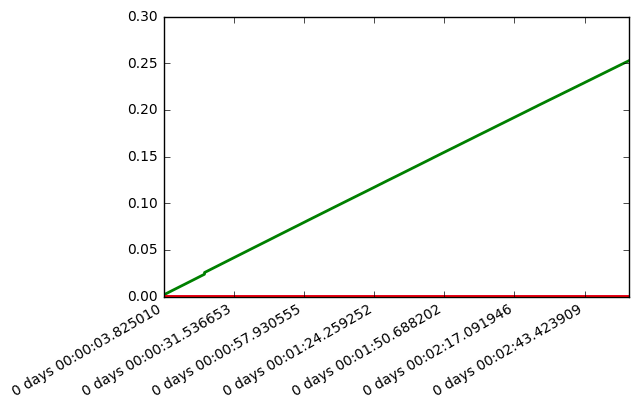

In [411]:
est_status.t_estimator_status_0__f_covariances_15_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_16_[:'2 m'].plot()
est_status.t_estimator_status_0__f_covariances_17_[:'2 m'].plot()